In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GatedGraphConv
import random
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def parse_tsp_line(line):
    # Split the line into parts
    parts = line.strip().split()
    
    # Extract coordinates
    coord_count = parts.index('output')
    coordinates = torch.tensor(list(map(float, parts[:coord_count]))).view(-1, 2)  # Shape (n, 2)
    
    # Extract tour, excluding the last repeated node
    tour = list(map(int, parts[coord_count + 1:-1]))  # Exclude the last node
    
    # Generate edge index for the tour
    edge_index = []
    for i in range(len(tour) - 1):
        edge_index.append((tour[i] - 1, tour[i + 1] - 1))  # Convert to 0-indexed
    edge_index.append((tour[-1] - 1, tour[0] - 1))  # Close the loop
    edge_index = torch.tensor(edge_index).t()  # Shape (2, n_edges)
    
    return coordinates, edge_index

# Example usage
line = "0.1 0.2 0.3 0.4 0.5 0.6 output 2 3 1 2"
coordinates, edge_index = parse_tsp_line(line)
print("Coordinates:", coordinates)
print("Edge Index:", edge_index)


Coordinates: tensor([[0.1000, 0.2000],
        [0.3000, 0.4000],
        [0.5000, 0.6000]])
Edge Index: tensor([[1, 2, 0],
        [2, 0, 1]])


In [4]:
percentage = 0.001
num_samples = int(1000000 * percentage)
num_samples = 100

In [5]:
def load_tsp_data(file_path):
    graphs = []
    with open(file_path, 'r') as f:
        for line in f:
            coordinates, edge_index = parse_tsp_line(line)
            graphs.append((coordinates, edge_index))
    return graphs

In [ ]:
def sample_data(file_path, num_samples):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    sampled_lines = random.sample(lines, num_samples)
    return [parse_tsp_line(line) for line in sampled_lines]

train_data = sample_data(f'tsp_data/combined_train.txt', num_samples=num_samples)


In [7]:
def prepare_graph(coordinates, edge_index):
    num_nodes = coordinates.size(0)
    
    # Create fully connected edges
    all_edges = torch.combinations(torch.arange(num_nodes), r=2).t()
    
    # Compute edge attributes (distances)
    edge_attr = torch.norm(coordinates[all_edges[0]] - coordinates[all_edges[1]], dim=1, keepdim=True)
    
    # Create labels: 1 for edges in the tour, 0 otherwise
    labels = torch.zeros(all_edges.size(1))
    for i in range(edge_index.size(1)):
        for j in range(all_edges.size(1)):
            if torch.equal(edge_index[:, i], all_edges[:, j]):
                labels[j] = 1
    
    return coordinates, all_edges, edge_attr, labels

# Example usage
coordinates, edge_index = train_data[0]
x, all_edges, edge_attr, labels = prepare_graph(coordinates, edge_index)
print("Node Features (x):", x)
print("Edge Index:", all_edges)
print("Edge Attributes (distances):", edge_attr)
print("Labels:", labels)

Node Features (x): tensor([[0.6304, 0.4763],
        [0.0113, 0.7137],
        [0.0728, 0.5035],
        [0.2501, 0.9112],
        [0.2101, 0.7470],
        [0.0876, 0.5057],
        [0.3032, 0.3892],
        [0.9035, 0.6023],
        [0.8621, 0.3437],
        [0.1597, 0.5528],
        [0.2228, 0.0090],
        [0.6957, 0.9856],
        [0.8768, 0.1406],
        [0.3263, 0.7190],
        [0.7190, 0.2888],
        [0.8880, 0.5173],
        [0.8054, 0.9061],
        [0.5713, 0.0501],
        [0.4678, 0.9522],
        [0.9977, 0.5279]])
Edge Index: tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5

In [8]:
class TSPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(TSPModel, self).__init__()
        self.num_layers = num_layers

        # GraphSAGE layers
        self.graphsage_layers = nn.ModuleList()
        self.graphsage_layers.append(SAGEConv(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.graphsage_layers.append(SAGEConv(hidden_dim, hidden_dim))

        # GatedGCN
        self.gated_gcn = GatedGraphConv(out_channels=hidden_dim, num_layers=num_layers)

        # MLP for adjacency matrix predictions
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        # Apply GraphSAGE layers
        for layer in self.graphsage_layers:
            x = layer(x, edge_index)
            x = F.relu(x)

        # Apply GatedGCN
        x = self.gated_gcn(x, edge_index, edge_attr)

        # Predict edge probabilities
        edge_predictions = []
        for edge in edge_index.t():
            h_i, h_j = x[edge[0]], x[edge[1]]
            edge_pred = self.mlp(torch.cat([h_i, h_j], dim=-1))
            edge_predictions.append(edge_pred)

        return torch.cat(edge_predictions, dim=0)


In [9]:
# Configuration
INPUT_DIM = 2  # Coordinates of cities
HIDDEN_DIM = 128
NUM_LAYERS = 5
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Instantiate the model
model = TSPModel(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
val_data = load_tsp_data('tsp_data/combined_val.txt')
test_data = load_tsp_data('tsp_data/combined_test.txt')

In [10]:
def evaluate_model(model, data):
    model.eval()
    total_loss = 0
    for coordinates, edge_index in data:
        x, all_edges, edge_attr, labels = prepare_graph(coordinates, edge_index)
        x, all_edges, edge_attr, labels = x.to(device), all_edges.to(device), edge_attr.to(device), labels.to(device)
        with torch.no_grad():
            predictions = model(x, all_edges, edge_attr)
        loss = loss_fn(predictions.view(-1), labels)
        total_loss += loss.item()
    return total_loss / len(data)

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

def test_model(model, num_nodes=10):
    model.eval()  # Set the model to evaluation mode
    
    # Generate a random graph
    city_coordinates = torch.rand(num_nodes, 2)  # Random 2D coordinates for cities
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()  # Fully connected edges
    edge_attr = torch.norm(city_coordinates[edge_index[0]] - city_coordinates[edge_index[1]], dim=1, keepdim=True)  # Euclidean distance as edge weights
    
    city_coordinates, edge_index, edge_attr = city_coordinates.to(device), edge_index.to(device), edge_attr.to(device)
    # Make predictions
    with torch.no_grad():
        predictions = model(city_coordinates, edge_index, edge_attr)
    
    predictions = predictions.cpu()
    print("Predictions: ", predictions)
    city_coordinates, edge_index, edge_attr = city_coordinates.cpu(), edge_index.cpu(), edge_attr.cpu()
    # Get the predicted adjacency matrix
    edge_probs = torch.sigmoid(predictions).view(-1)  # Convert logits to probabilities
    predicted_edges = edge_index[:, edge_probs > 0.5]  # Threshold to decide if an edge is in the tour
    print("edge_probs:", edge_probs)
    print("predicted_edges: ", predicted_edges.t().tolist())
    print("OUT")
    
    # Ensure the tour is valid
    # Use a simple heuristic like connecting the predicted edges greedily into a valid cycle
    tour_edges = validate_and_construct_tour(predicted_edges, num_nodes)
    
    # Visualize the tour
    visualize_tour(city_coordinates, tour_edges)

def validate_and_construct_tour(edges, num_nodes):
    edges_list = edges.t().tolist()
    
    # Remove duplicate edges and ensure correct ordering (u, v) with u < v
    edges_cleaned = edges_list #list(set(map(tuple, (min(u, v), max(u, v)) for u, v in edges_list)))
    
    # Create a NetworkX graph
    graph = nx.Graph()
    graph.add_edges_from(edges_cleaned)
    
    # Ensure graph has all nodes (in case some are isolated)
    graph.add_nodes_from(range(num_nodes))
    
    if nx.is_connected(graph):
        # Use a greedy Hamiltonian cycle heuristic
        start_node = 0  # Start from node 0
        tour = [start_node]
        visited = set(tour)
        
        current_node = start_node
        while len(visited) < num_nodes:
            neighbors = list(graph.neighbors(current_node))
            # Select the first unvisited neighbor
            next_node = next((n for n in neighbors if n not in visited), None)
            if next_node is None:
                raise ValueError("Cannot find a Hamiltonian cycle: Graph is not dense enough.")
            tour.append(next_node)
            visited.add(next_node)
            current_node = next_node
        
        # Close the cycle
        tour.append(start_node)
        
        # Convert to list of edges
        tour_edges = [(tour[i], tour[i + 1]) for i in range(len(tour) - 1)]
        return torch.tensor(tour_edges)
    else:
        raise ValueError("The graph is not connected, so a Hamiltonian cycle is impossible.")


def visualize_tour(city_coordinates, tour_edges):
    # Create a plot of the tour
    plt.figure(figsize=(8, 8))
    plt.scatter(city_coordinates[:, 0], city_coordinates[:, 1], color='blue', s=100, label='Cities')
    
    # Draw the edges of the tour
    for i, j in tour_edges:
        plt.plot([city_coordinates[i, 0], city_coordinates[j, 0]],
                 [city_coordinates[i, 1], city_coordinates[j, 1]], color='red')
    
    # Annotate cities with numbers
    for idx, (x, y) in enumerate(city_coordinates):
        plt.text(x, y, str(idx), fontsize=12, ha='right')
    
    plt.title("Predicted TSP Tour")
    plt.legend()
    plt.show()



In [12]:
for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    # Iterate over the training dataset
    for coordinates, edge_index in train_data:
        # Prepare graph
        x, all_edges, edge_attr, labels = prepare_graph(coordinates, edge_index)
        
        x, all_edges, edge_attr, labels = x.to(device), all_edges.to(device), edge_attr.to(device), labels.to(device)
        # Forward pass
        predictions = model(x, all_edges, edge_attr)
        
        # Compute loss
        loss = loss_fn(predictions.view(-1), labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {loss.item()}")

print("Training complete.")


Epoch 1/10, Loss: 52.64574432373047
Epoch 2/10, Loss: 52.49509048461914
Epoch 3/10, Loss: 53.41916275024414
Epoch 4/10, Loss: 53.202178955078125
Epoch 5/10, Loss: 52.898582458496094
Epoch 6/10, Loss: 53.60211944580078
Epoch 7/10, Loss: 52.502593994140625
Epoch 8/10, Loss: 52.76233673095703
Epoch 9/10, Loss: 52.44964599609375
Epoch 10/10, Loss: 52.47819519042969
Training complete.


In [ ]:
val_loss = evaluate_model(model, val_data)
print(f"Validation Loss: {val_loss}")

Predictions:  tensor([0.1225, 0.0990, 0.0990, 0.2002, 0.2002, 0.2289])
edge_probs: tensor([0.5306, 0.5247, 0.5247, 0.5499, 0.5499, 0.5570])
predicted_edges:  [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
OUT


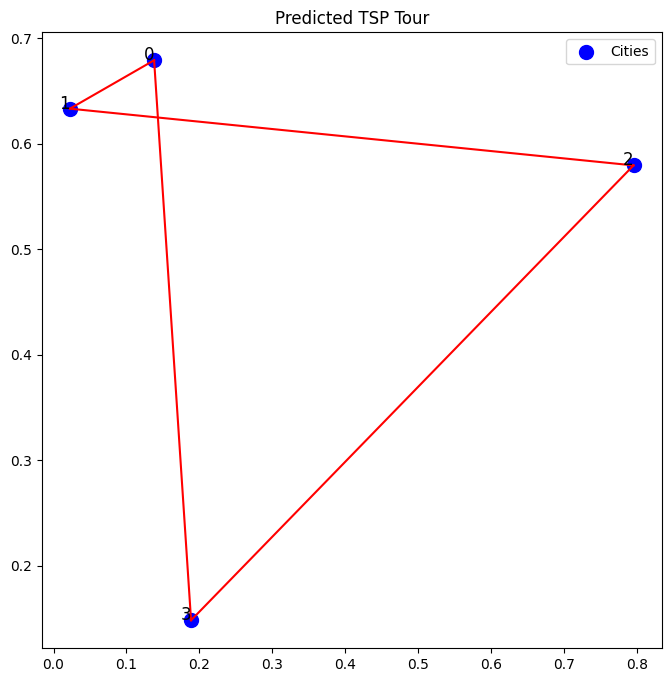

In [ ]:
# Test the trained model
test_model(model, num_nodes=4)